In [1]:
import sys
sys.path.append("/home/tinkerer/cloned_repos/spin-qubit/codes/")
sys.path.insert(0, "/home/clonned_repos/Poisson_Solver")

In [4]:
from ccode.gates_trijunction import gates_trijunction
import numpy as np
import matplotlib.pyplot as plt
from potential import gate_potential, linear_problem_instance
from Hamiltonian import discrete_system_coordinates, kwant_system
from scipy import constants
from utility import prepare_voltages
from plotting import plot_potential
import kwant
from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    SimpleVoltageLayer,
    TwoDEGLayer,
)

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [27]:
thickness_GaAs = 6
thickness_twoDEG = 9
thickness_Al2O3 = 5
thickness_gate = 4
thickness_self_Al2O3 = 0.5

meff = 0.067 * constants.m_e  # in Kg
eV = 1.0
bandgap_GaAs = 1.519 * eV

permittivity_metal = 5000
permittivity_GaAs = 12.18
permittivity_twoDEG = 12.9
permittivity_air = 1.0

grid_spacing_twoDEG = 1
grid_spacing_normal = 1
grid_spacing_dielectric = 5
grid_spacing_air = 5
grid_spacing_GaAs = grid_spacing_normal
grid_spacing_gate = grid_spacing_twoDEG

density = 1.9e11  # Electron density in 2DEG per cm2
cm = 1.0
m = 1e2 * cm
density_m2 = density * m ** 2  # Electron density in 2DEG per m2
#scaling_eV = 1 / (constants.e)  # in eV
#mu = (((constants.hbar ** 2) * np.pi * density_m2) / meff) * scaling_eV

In [28]:
area = 3000
angle = np.pi/4
wire_width = 7
gap = 3
extra_width = 30

In [29]:
triangle_length = np.sqrt(area*np.tan(angle))
triangle_width = np.abs((triangle_length/np.tan(angle)))
top_shift = np.tan(angle)*(wire_width/2)
tunnel_length = wire_width
tunnel_width = wire_width

total_length = triangle_length + 2 * tunnel_length + 2 * gap - top_shift
total_width = 2 * extra_width + triangle_width

In [30]:
gates = gates_trijunction(area, angle, wire_width, gap, extra_width)

In [31]:
zmin = -0.5
zmax = 0.5
xmax = triangle_length/2 + extra_width/2
xmin = -xmax
ymin = 0
ymax = total_length
boundaries = [xmin, xmax, ymin, ymax, zmin, zmax]

In [32]:
boundaries

[-42.3861278752583, 42.3861278752583, 0, 71.2722557505166, -0.5, 0.5]

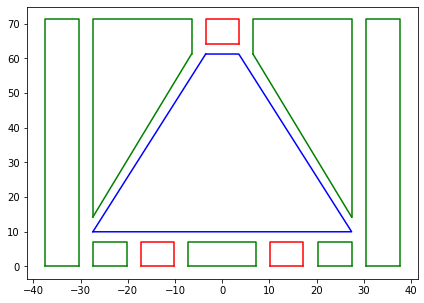

In [33]:
plt.figure(figsize=(7, 5))

for _, gate in gates["screening_gates"].items():
    plt.plot(gate[:, 0], gate[:, 1], "g")
    plt.plot([gate[0, 0], gate[-1, 0]], [gate[0, 1], gate[-1, 1]], "g")
    
for _, gate in gates["tunnel_gates"].items():
    plt.plot(gate[:, 0], gate[:, 1], "r")
    plt.plot([gate[0, 0], gate[-1, 0]], [gate[0, 1], gate[-1, 1]], "r")

for _, gate in gates["back_gates"].items():
    plt.plot(gate[:, 0], gate[:, 1], "b")
    plt.plot([gate[0, 0], gate[-1, 0]], [gate[0, 1], gate[-1, 1]], "b")



In [34]:
layout = Layout(
    total_width, total_length, grid_width_air=grid_spacing_air, margin=(50, 50, 50), shift=(0, 0, 0)
)

In [35]:
layout.add_layer(
    TwoDEGLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG
    ),
    center=True,
)

layout.add_layer(
    SimpleChargeLayer(
        "GaAs",
        thickness_GaAs,
        permittivity_GaAs,
        grid_spacing_GaAs,
    )
)



In [36]:
vertex = (
    list(gates["back_gates"].values()),
    list(gates["screening_gates"].values()),
    list(gates["tunnel_gates"].values()),
        )

layout.add_layer(
    OverlappingGateLayer(
        vertex,
        np.hstack([list(gates[key].keys()) for key, _ in gates.items()]),
        thickness_gate,
        thickness_self_Al2O3,
        permittivity_metal,
        grid_spacing_gate,
    )
)

In [37]:
%%time
poisson_system = layout.build()
linear_problem = linear_problem_instance(poisson_system)

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix
CPU times: user 1min, sys: 4.92 s, total: 1min 5s
Wall time: 1min 5s


In [38]:
site_coords, site_indices = discrete_system_coordinates(
    poisson_system, [('charge','GaAs'), ('mixed', 'twoDEG')], boundaries
)

In [39]:
site_coords

array([[-42. ,   0.5,   0. ],
       [-42. ,   1.5,   0. ],
       [-42. ,   2.5,   0. ],
       ...,
       [ 42. ,  33.5,   0. ],
       [ 42. ,  34.5,   0. ],
       [ 42. ,  35.5,   0. ]])

In [40]:
# %%px --local

model = "A0 * (k_x**2 + k_y**2) + V(x, y)"

A0 = (constants.hbar) ** 2 / (2 * meff * constants.e * (1e-9) ** 2)


def onsite(site, A0, V):
    (x, y,) = site.pos
    _const_0 = V(x, y)
    return (4 / (grid_spacing) ** 2) * A0 + _const_0


def hopping(site1, site2, A0):
    return -(1 / (grid_spacing) ** 2) * A0


grid_spacing = grid_spacing_twoDEG
kwant_syst = kwant_system(site_coords[:, [0, 1]], onsite, hopping, grid_spacing)
kwant_sites = np.array([site.pos for site in kwant_syst.sites])

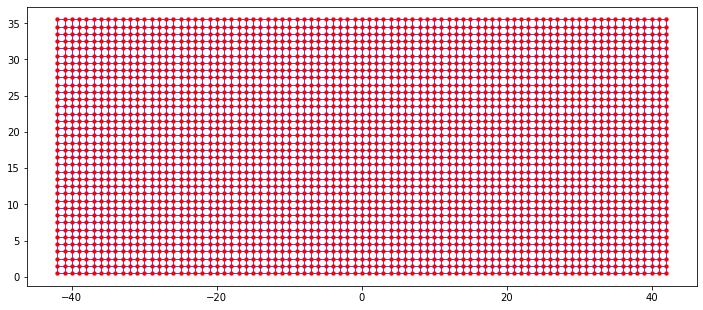

In [41]:
kwant.plot(kwant_syst, site_size=0.3, site_color='r', hop_color='b', fig_size=(12, 10));

In [42]:
voltages = {
    'back_gate': 0.056,
    'left_triangle_screen_gate': -5,
    'right_triangle_screen_gate': -5,
    'low_top_screen_gate': -2,
    'low_left_screen_gate': -1,
    'low_right_screen_gate': -1,
    'left_screen_gate': -3,
    'right_screen_gate': -3,
    'top_tunnel_gate': 0.056,
    'left_tunnel_gate': 0.056,
   'right_tunnel_gate': 0.056
}
volt = list(voltages.values())
gates = list(voltages.keys())
voltages = prepare_voltages(volt, gates)
charges = {}

electrons = 1.0  # We consider electrons

sign_potential_energy = -1.0 if electrons else 1.0

In [43]:
clean_potential = gate_potential(
    poisson_system,
    linear_problem,
    site_coords[:, [0, 1]],
    site_indices,
    voltages,
    charges
)

In [44]:
clean_potential.update(
    (key, sign_potential_energy * value) for key, value in clean_potential.items()
)

IndexError: index 0 is out of bounds for axis 0 with size 0

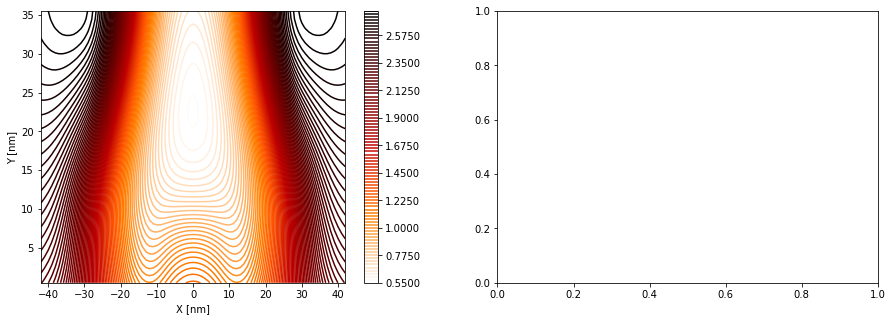

In [45]:
plot_potential([clean_potential], [0.0])